In [12]:
import pandas as pd

df = pd.read_csv("output_partial.csv", index_col=0)

df.head()

df.shape


/tmp/ipykernel_27012/2753241219.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("output_partial.csv", index_col=0)


(407000, 10)

In [13]:
# output all parties mentioned in the dataset
parties = set()
for i, row in df.iterrows():
    if isinstance(row['party'], str):
        for party in row['party'].split(','):
            parties.add(party.strip())
print("Parties mentioned in the dataset:")
for party in sorted(parties):
    print(party)


Parties mentioned in the dataset:
BBB
CDA
D66
GroenLinks
PVV
SP
VVD


In [14]:
# output all spekaers mentioned in the dataset
speakers = set()
for i, row in df.iterrows():
    if isinstance(row['speaker'], str):
        for speaker in row['speaker'].split(','):
            speakers.add(speaker.strip())
print("Speakers mentioned in the dataset:")
for speaker in sorted(speakers):
    print(speaker)

Speakers mentioned in the dataset:
Aardema
Aartsen
Adema
Adriaansens
Agema
Agnes Mulder
Alkaya
Amhaouch
Anne Mulder
Antwoord
Aptroot
Arno Rutte
Asscher
Atsma
Aukje de Vries
Azmani
Azough
Balkenende
Bamenga
Bashir
Becker
Beckerman
Beertema
Belhaj
Beljaarts
Berckmoes-Duindam
Bergkamp
Berndsen
Berndsen-Jansen
Bevers
Bijleveld
Biskop
Blaauw
Blanksma-van den Heuvel
Blok
Boekestijn
Boekhoudt
Bolkestein
Bontenbal
Bontes
Boon
Bos
Bosma
Bosman
Bosman De heer Bosman
Boswijk
Boszeiwekengeleden
Bouali
Bouchallikh
Boucke
Boulakjar
Boutkan
Braakhuis
Brekelmans
Brinkman
Bromet
Bruins
Bruins Slot
Buijsse
Buitenweg
Bussemaker
Chris Simons
Claassen
Cramer
Crijns
De Boer
De Caluwé
De Graaf
De Graaf namens de PVV De heer De Graaf
De Groot
De Jager
De Jong
De Jonge
De Kort
De Krom
De Lange
De Liefde
De Mos
De Neef
De Neree tot Babberich
De Nerée tot Babberich
De Pater-Postma
De Roon
De Rouwe
De Vree
De Vries
De Wit
Deen
Dekker
Dekker-Abdulaziz
Den Boer
Dezentje Hamming-Bluemink
Dezentjé Hamming-Bluemink
Di

In [20]:
# show party for speaker Wiersma
print("Party for speaker Wiersma:")
print(df[df['speaker'].str.contains('Wiersma', na=False)]['party'].unique())

# show party for speaker Agema
print("Party for speaker Agema:")
print(df[df['speaker'].str.contains('Agema', na=False)]['party'].unique())

# show party for speaker Van der Plas
print("Party for speaker Van der Plas:")
print(df[df['speaker'].str.contains('Van der Plas', na=False)]['party'].unique())

# show party for speaker Baudet
print("Party for speaker Baudet:")
print(df[df['speaker'].str.contains('Baudet', na=False)]['party'].unique())

# show party for speaker Wilders
print("Party for speaker Wilders:")
print(df[df['speaker'].str.contains('Wilders', na=False)]['party'].unique())

# show party for speaker Balkenende
print("Party for speaker Balkenende:")
print(df[df['speaker'].str.contains('Balkenende', na=False)]['party'].unique())

Party for speaker Wiersma:
['VVD']
Party for speaker Agema:
['PVV']
Party for speaker Van der Plas:
['BBB']
Party for speaker Baudet:
[]
Party for speaker Wilders:
['PVV']
Party for speaker Balkenende:
[]


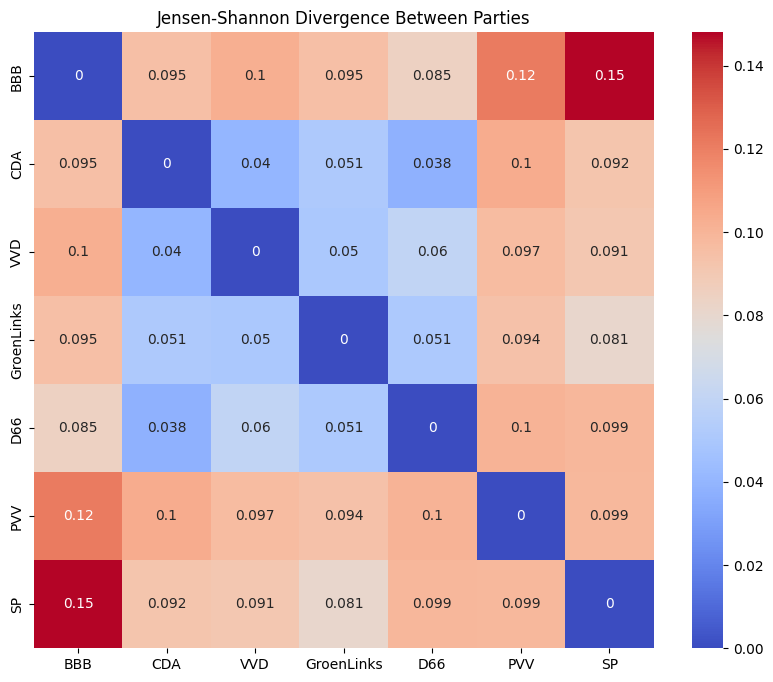

In [16]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with no party
df = df.dropna(subset=['party'])

# Step 1: Build a topic distribution per speech
def build_topic_dist(row):
    dist = {}
    for i in range(1, 4):
        topic = row[f'top_{i}_topic']
        prob = row[f'top_{i}_prob']
        if isinstance(topic, str) and ' - ' in topic:
            topic_id = topic.split(' - ')[0].strip()
            dist[topic_id] = dist.get(topic_id, 0) + prob
    return dist

df['topic_dist'] = df.apply(build_topic_dist, axis=1)

# Step 2: Aggregate distributions per party
from collections import defaultdict

party_topic_counts = defaultdict(lambda: defaultdict(float))

for _, row in df.iterrows():
    party = row['party']
    for topic, prob in row['topic_dist'].items():
        party_topic_counts[party][topic] += prob

# Get all unique topics
all_topics = sorted({topic for counts in party_topic_counts.values() for topic in counts})

# Step 3: Normalize to probability distributions
party_dists = {}
for party, topic_count in party_topic_counts.items():
    vec = np.array([topic_count.get(topic, 0) for topic in all_topics])
    vec = vec / vec.sum()  # normalize
    party_dists[party] = vec

# Step 4: Compute pairwise Jensen-Shannon divergence
party_names = list(party_dists.keys())
jsd_matrix = pd.DataFrame(index=party_names, columns=party_names, dtype=float)

for p1, p2 in combinations(party_names, 2):
    d1 = party_dists[p1]
    d2 = party_dists[p2]
    jsd = jensenshannon(d1, d2, base=2)
    jsd_matrix.loc[p1, p2] = jsd
    jsd_matrix.loc[p2, p1] = jsd

np.fill_diagonal(jsd_matrix.values, 0.0)

# Optional: Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(jsd_matrix.astype(float), annot=True, cmap="coolwarm")
plt.title("Jensen-Shannon Divergence Between Parties")
plt.show()


/tmp/ipykernel_27012/3706564153.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(jsd_matrix, method='average')


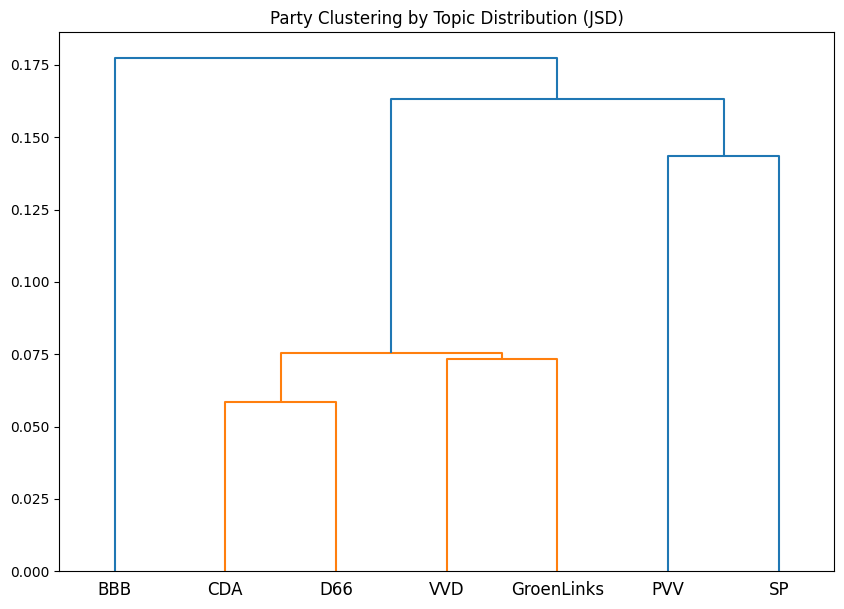

In [17]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

linked = linkage(jsd_matrix, method='average')

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=jsd_matrix.index, orientation='top')
plt.title("Party Clustering by Topic Distribution (JSD)")
plt.show()


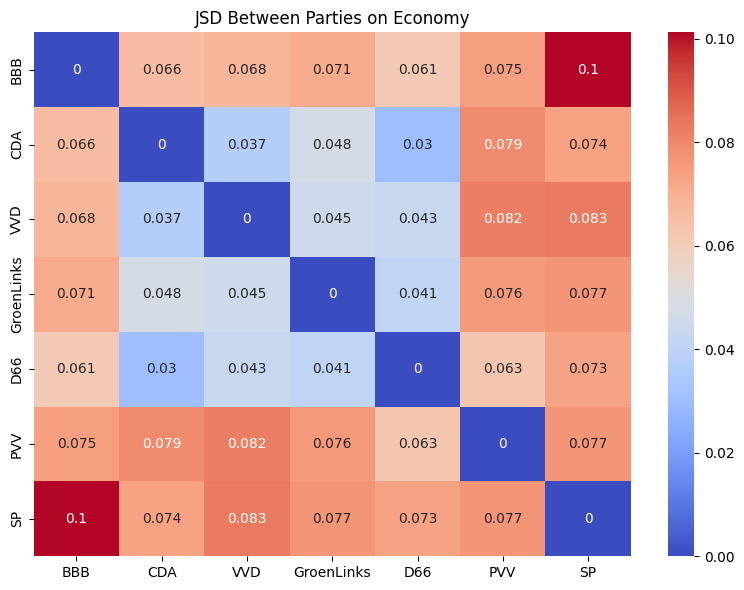

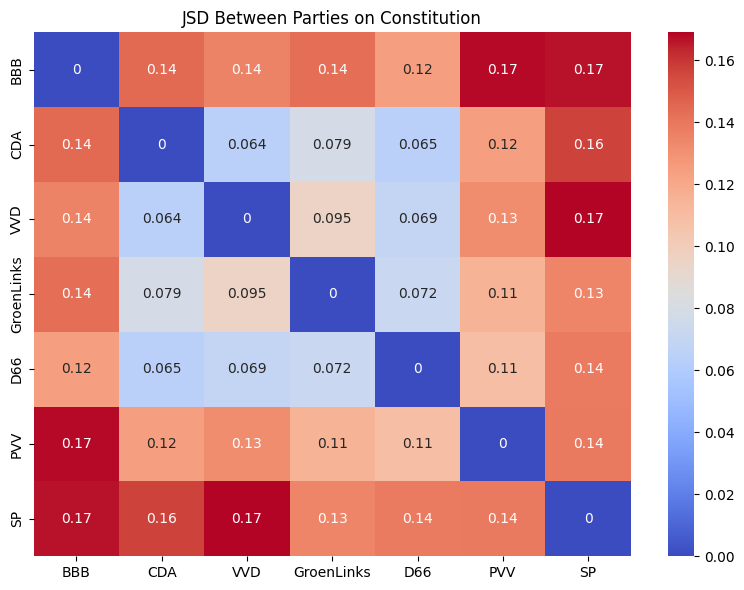

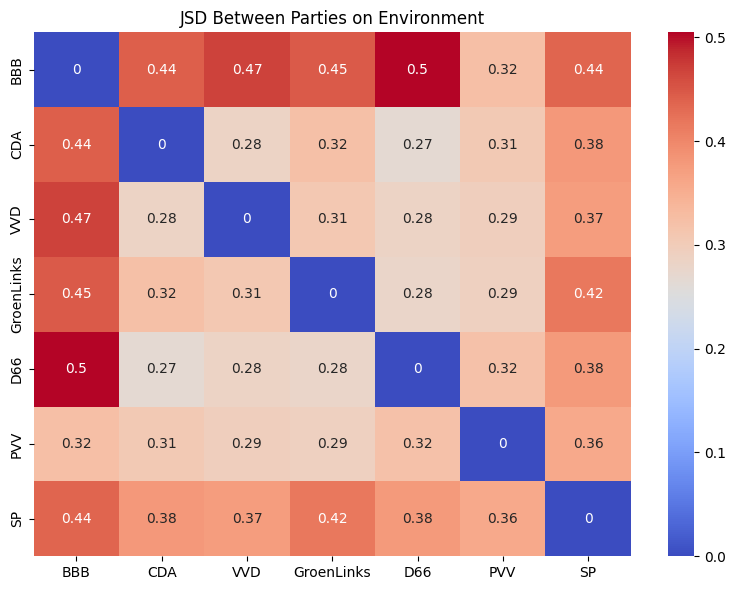

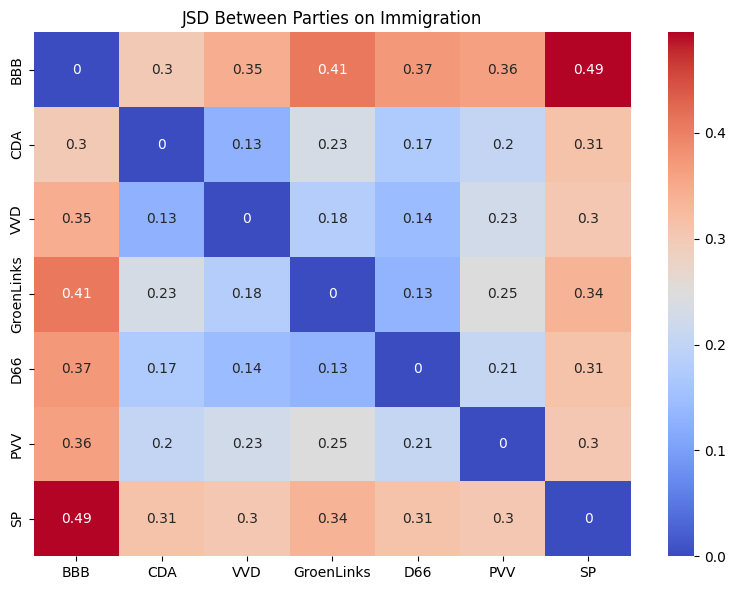

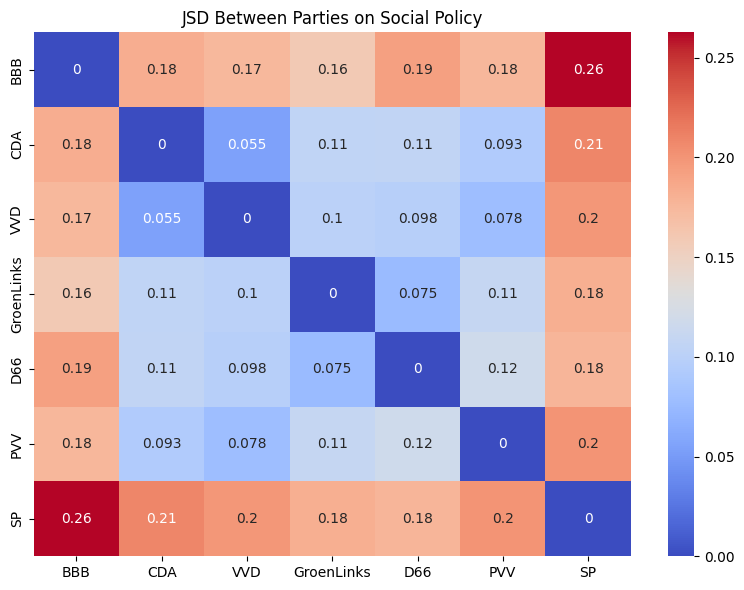

In [19]:
issue_groups = {
    'Economy': {'412', '413', '415'},
    'Constitution': {'203', '204'},
    'Environment': {'601', '602'},
    'Immigration': {'701', '702'},
    'Social Policy': {'501', '502'},
    # Add more based on your full topic list
}


def get_issues_for_speech(row, issue_groups):
    issues = set()
    for i in range(1, 4):
        topic = row.get(f'top_{i}_topic', '')
        if isinstance(topic, str) and ' - ' in topic:
            topic_id = topic.split(' - ')[0].strip()
            for issue, topic_ids in issue_groups.items():
                if topic_id in topic_ids:
                    issues.add(issue)
    return list(issues)

df['issues'] = df.apply(get_issues_for_speech, axis=1, issue_groups=issue_groups)


from collections import defaultdict
from scipy.spatial.distance import jensenshannon
import pandas as pd
import numpy as np

issue_jsd_results = {}

for issue in issue_groups.keys():
    subset = df[df['issues'].apply(lambda x: issue in x)]
    if subset.empty:
        continue

    # Aggregate topic distributions per party
    party_topic_counts = defaultdict(lambda: defaultdict(float))
    
    for _, row in subset.iterrows():
        party = row['party']
        if pd.isna(party):
            continue
        for topic, prob in row['topic_dist'].items():
            party_topic_counts[party][topic] += prob

    all_topics = sorted({topic for counts in party_topic_counts.values() for topic in counts})

    party_dists = {}
    for party, topic_count in party_topic_counts.items():
        vec = np.array([topic_count.get(topic, 0) for topic in all_topics])
        if vec.sum() == 0:
            continue
        vec = vec / vec.sum()
        party_dists[party] = vec

    party_names = list(party_dists.keys())
    jsd_matrix = pd.DataFrame(index=party_names, columns=party_names, dtype=float)

    for p1 in party_names:
        for p2 in party_names:
            if p1 == p2:
                jsd = 0.0
            else:
                jsd = jensenshannon(party_dists[p1], party_dists[p2], base=2)
            jsd_matrix.loc[p1, p2] = jsd

    issue_jsd_results[issue] = jsd_matrix



import seaborn as sns
import matplotlib.pyplot as plt

for issue, matrix in issue_jsd_results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix.astype(float), annot=True, cmap='coolwarm')
    plt.title(f"JSD Between Parties on {issue}")
    plt.tight_layout()
    plt.show()

